* `Автор:` Шанарова Надежда Леонидовна
* `Почта:` nadya.shanarova@gmail.com
* `Телеграм:` @kronesine

In [ ]:
%load_ext autoreload
%autoreload 2

import os
os.environ['CUDA_VISIBLE_DEVICES']=''

import sys;
# path to t5-experiments repo
sys.path.append('..')

In [668]:
from tokenizers.models import Unigram
from transformers import T5Config, T5Tokenizer, T5ForConditionalGeneration
from tokenizers import Tokenizer
from transformers import PreTrainedTokenizerFast
from transformers import AutoModelForSeq2SeqLM, DataCollatorForSeq2Seq, Seq2SeqTrainingArguments, Seq2SeqTrainer
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import transformers
from transformers import AutoTokenizer
from transformers import DataCollatorForLanguageModeling
from datasets import load_dataset
from torch.utils.data import Dataset, DataLoader
from transformers import Trainer, TrainingArguments
import pandas as pd
import nltk
#nltk.download('punkt')
import string
from transformers import T5Config, T5Tokenizer, T5ForConditionalGeneration
%matplotlib inline
from transformers import AutoModelForSeq2SeqLM, DataCollatorForSeq2Seq, Seq2SeqTrainingArguments, Seq2SeqTrainer



# Load model

Модель была выбрана с такими параметрами:
t5-base-head_4-layer_6-optim_adamw_torch-lr_0.0001-lr_scheduler_type_linear

In [242]:
from transformers import T5Tokenizer, T5ForConditionalGeneration

model = T5ForConditionalGeneration.from_pretrained('./t5-base_new_-head_4-layer_6-optim_adamw_torch-lr_0.0001-lr_scheduler_type_linear/checkpoint-140000', return_dict=True)

In [669]:
from datasets import load_dataset

dataset = load_dataset('csv', data_files={'train': 'dataset_train_eq.csv',
                                'val': 'dataset_test_eq.csv'})


Using custom data configuration default-62e62c27a7c05eca
Reusing dataset csv (/root/.cache/huggingface/datasets/csv/default-62e62c27a7c05eca/0.0.0/51cce309a08df9c4d82ffd9363bbe090bf173197fc01a71b034e8594995a1a58)


  0%|          | 0/2 [00:00<?, ?it/s]

In [670]:
import nltk
import numpy as np


def compute_metrics4token(eval_pred):
    batch_size = 32
    predictions, labels = eval_pred
    print(predictions[0:2])
    print(labels[0:2])
    print("------")
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    # Replace -100 in the labels as we can't decode them.
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
    # Rouge expects a newline after each sentence
    decoded_preds =  ["\n".join(nltk.sent_tokenize(pred.strip())) for pred in decoded_preds]
    decoded_labels =  ["\n".join(nltk.sent_tokenize(label.strip())) for label in decoded_labels]
    answer_accuracy = []
    token_accuracy = []
    num_correct, num_total = 0, 0
    num_answer = 0
    number_eq = 0
    print(decoded_preds[:2])
    print(decoded_labels[:2])
    for p, l in zip(decoded_preds, decoded_labels):
        text_pred = p.split(' ')
        text_labels = l.split(' ')
        m = min(len(text_pred), len(text_labels))
        if np.array_equal(text_pred, text_labels):
            num_answer += 1
        for i, j in zip(text_pred, text_labels):
            if i == j:
                num_correct += 1
        num_total += len(text_labels)
        number_eq += 1
    token_accuracy = num_correct / num_total
    answer_accuracy = num_answer / number_eq   
    # Extract a few results
    result = {'token_acc': token_accuracy, 'answer_acc': answer_accuracy}
    result = {key: value for key, value in result.items()}
    for key, value in result.items():
        wandb.log({key: value})        
    return {k: round(v, 4) for k, v in result.items()}


In [672]:
tokenizer = PreTrainedTokenizerFast(tokenizer_object= Tokenizer.from_file("./tokenizer.json"))

Проверка:

In [735]:
inputses = "7x^2+3556x+451612=0"
labels = "D=(3556^2-4*7*451612)=0;x=(-3556-0)/(2*7)=-254; x=(-3556+0)/(2*7)=-254;x=-254;x=-254"

input_ids = tokenizer(""+inputses, return_tensors="pt").input_ids 
label_ids = tokenizer(""+labels, return_tensors="pt").input_ids 

outputs = model.generate(input_ids, return_dict=True, output_attentions=True)
decoded = tokenizer.decode(outputs[0], skip_special_tokens=True)

print(decoded)

D = ( 3 5 5 6 ^ 2 - 4 * 7 * 4 5 1 6 1 2 ) = 0 ; x = ( - 3 5 5 6 - 0 ) / ( 2 * 7 ) = - 2 5 4 ; x = ( - 3 5 5 6 + 0 ) / ( 2 * 7 ) = - 2 5 4 ; x = - 2 5 4 ; x = - 2 5 4


In [738]:
outputs = model(input_ids, decoder_input_ids=label_ids, return_dict=True, output_attentions=True)

In [739]:
outputs.keys()

odict_keys(['logits', 'past_key_values', 'decoder_attentions', 'cross_attentions', 'encoder_last_hidden_state', 'encoder_attentions'])

##### encoder_attentions

In [740]:
encoder_tokens = list(inputses)
encoder_attentions = outputs.encoder_attentions
len(encoder_attentions), encoder_attentions[0].shape

(6, torch.Size([1, 4, 19, 19]))

In [741]:
encoder_attentions[0].shape

torch.Size([1, 4, 19, 19])

In [742]:
len(encoder_attentions), encoder_attentions[0].shape

(6, torch.Size([1, 4, 19, 19]))

##### decoder_attentions

In [743]:
decoder_tokens = list(labels)
decoder_attentions = outputs.decoder_attentions
len(decoder_attentions), decoder_attentions[0].shape

(6, torch.Size([1, 4, 83, 83]))

In [745]:
decoder_attentions[0].shape

torch.Size([1, 4, 83, 83])

In [746]:
len(decoder_attentions), decoder_attentions[0].shape

(6, torch.Size([1, 4, 83, 83]))

##### cross_attentions

In [747]:
cross_attentions = outputs.cross_attentions
len(cross_attentions), cross_attentions[0].shape

(6, torch.Size([1, 4, 83, 19]))

In [748]:
cross_attentions[0].shape

torch.Size([1, 4, 83, 19])

In [749]:
len(cross_attentions), cross_attentions[0].shape

(6, torch.Size([1, 4, 83, 19]))

# Plot attentions

## encoder attentions

In [750]:
from matplotlib import pyplot as plt
%matplotlib inline

import numpy as np

def plot_attention_weights_enc(attentions, tokens, layer, y_tokens=None, p_attentions=None, filename='att.png', save=False):
    fig = plt.figure(figsize=(30, 180))
    if y_tokens is None:
        y_tokens = tokens
        fig = plt.figure(figsize=(30, 90))

    attention = attentions[layer]
    if p_attentions:
        p_attention = p_attentions[layer]

    for head in range(attention.shape[0]):
        ax = fig.add_subplot(6, 2, head+1)
        ax.xaxis.set_major_locator(MultipleLocator(0.5))
        ax.yaxis.set_major_locator(MultipleLocator(0.5))
        
        # plot the attention weights
        if p_attentions:
            att = np.concatenate([np.expand_dims(p_attention[head], axis=0), attention[head]], axis=0)
            ax.matshow(att[:len(y_tokens)+1,:len(tokens)], cmap='Reds')
        else:
            ax.matshow(attention[head][:len(y_tokens),:len(tokens)], cmap='Reds')

        fontdict = {'fontsize': 40}

        ax.set_xticks(range(len(tokens)))
        if p_attentions:
            ax.set_yticks(range(len(y_tokens) + 1))
            ax.set_yticklabels(['[P]'] + y_tokens, fontdict)
        else:
            ax.set_yticks(range(len(y_tokens)))
            ax.set_yticklabels(y_tokens, fontdict)

        ax.set_xticklabels(tokens,fontdict=fontdict, rotation=90)

        ax.set_xlabel('Head {}'.format(head+1), fontdict)
        ax.xaxis.set_minor_locator(AutoMinorLocator(1))
        ax.yaxis.set_minor_locator(AutoMinorLocator(1))

        ax.grid(which='major', color='#CCCCCC', linestyle='--')
        ax.grid(which='minor', color='#CCCCCC', linestyle=':')

    plt.tight_layout()
    if save:
        plt.savefig(filename)
    plt.show()

In [ ]:
encoder_attentions = [t.detach().numpy() for t in encoder_attentions]

**encoder_attentions on 1 layer:**

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: MatplotlibDeprecationWarning: Passing the fontdict parameter of _set_ticklabels() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.


<Figure size 2160x12960 with 0 Axes>

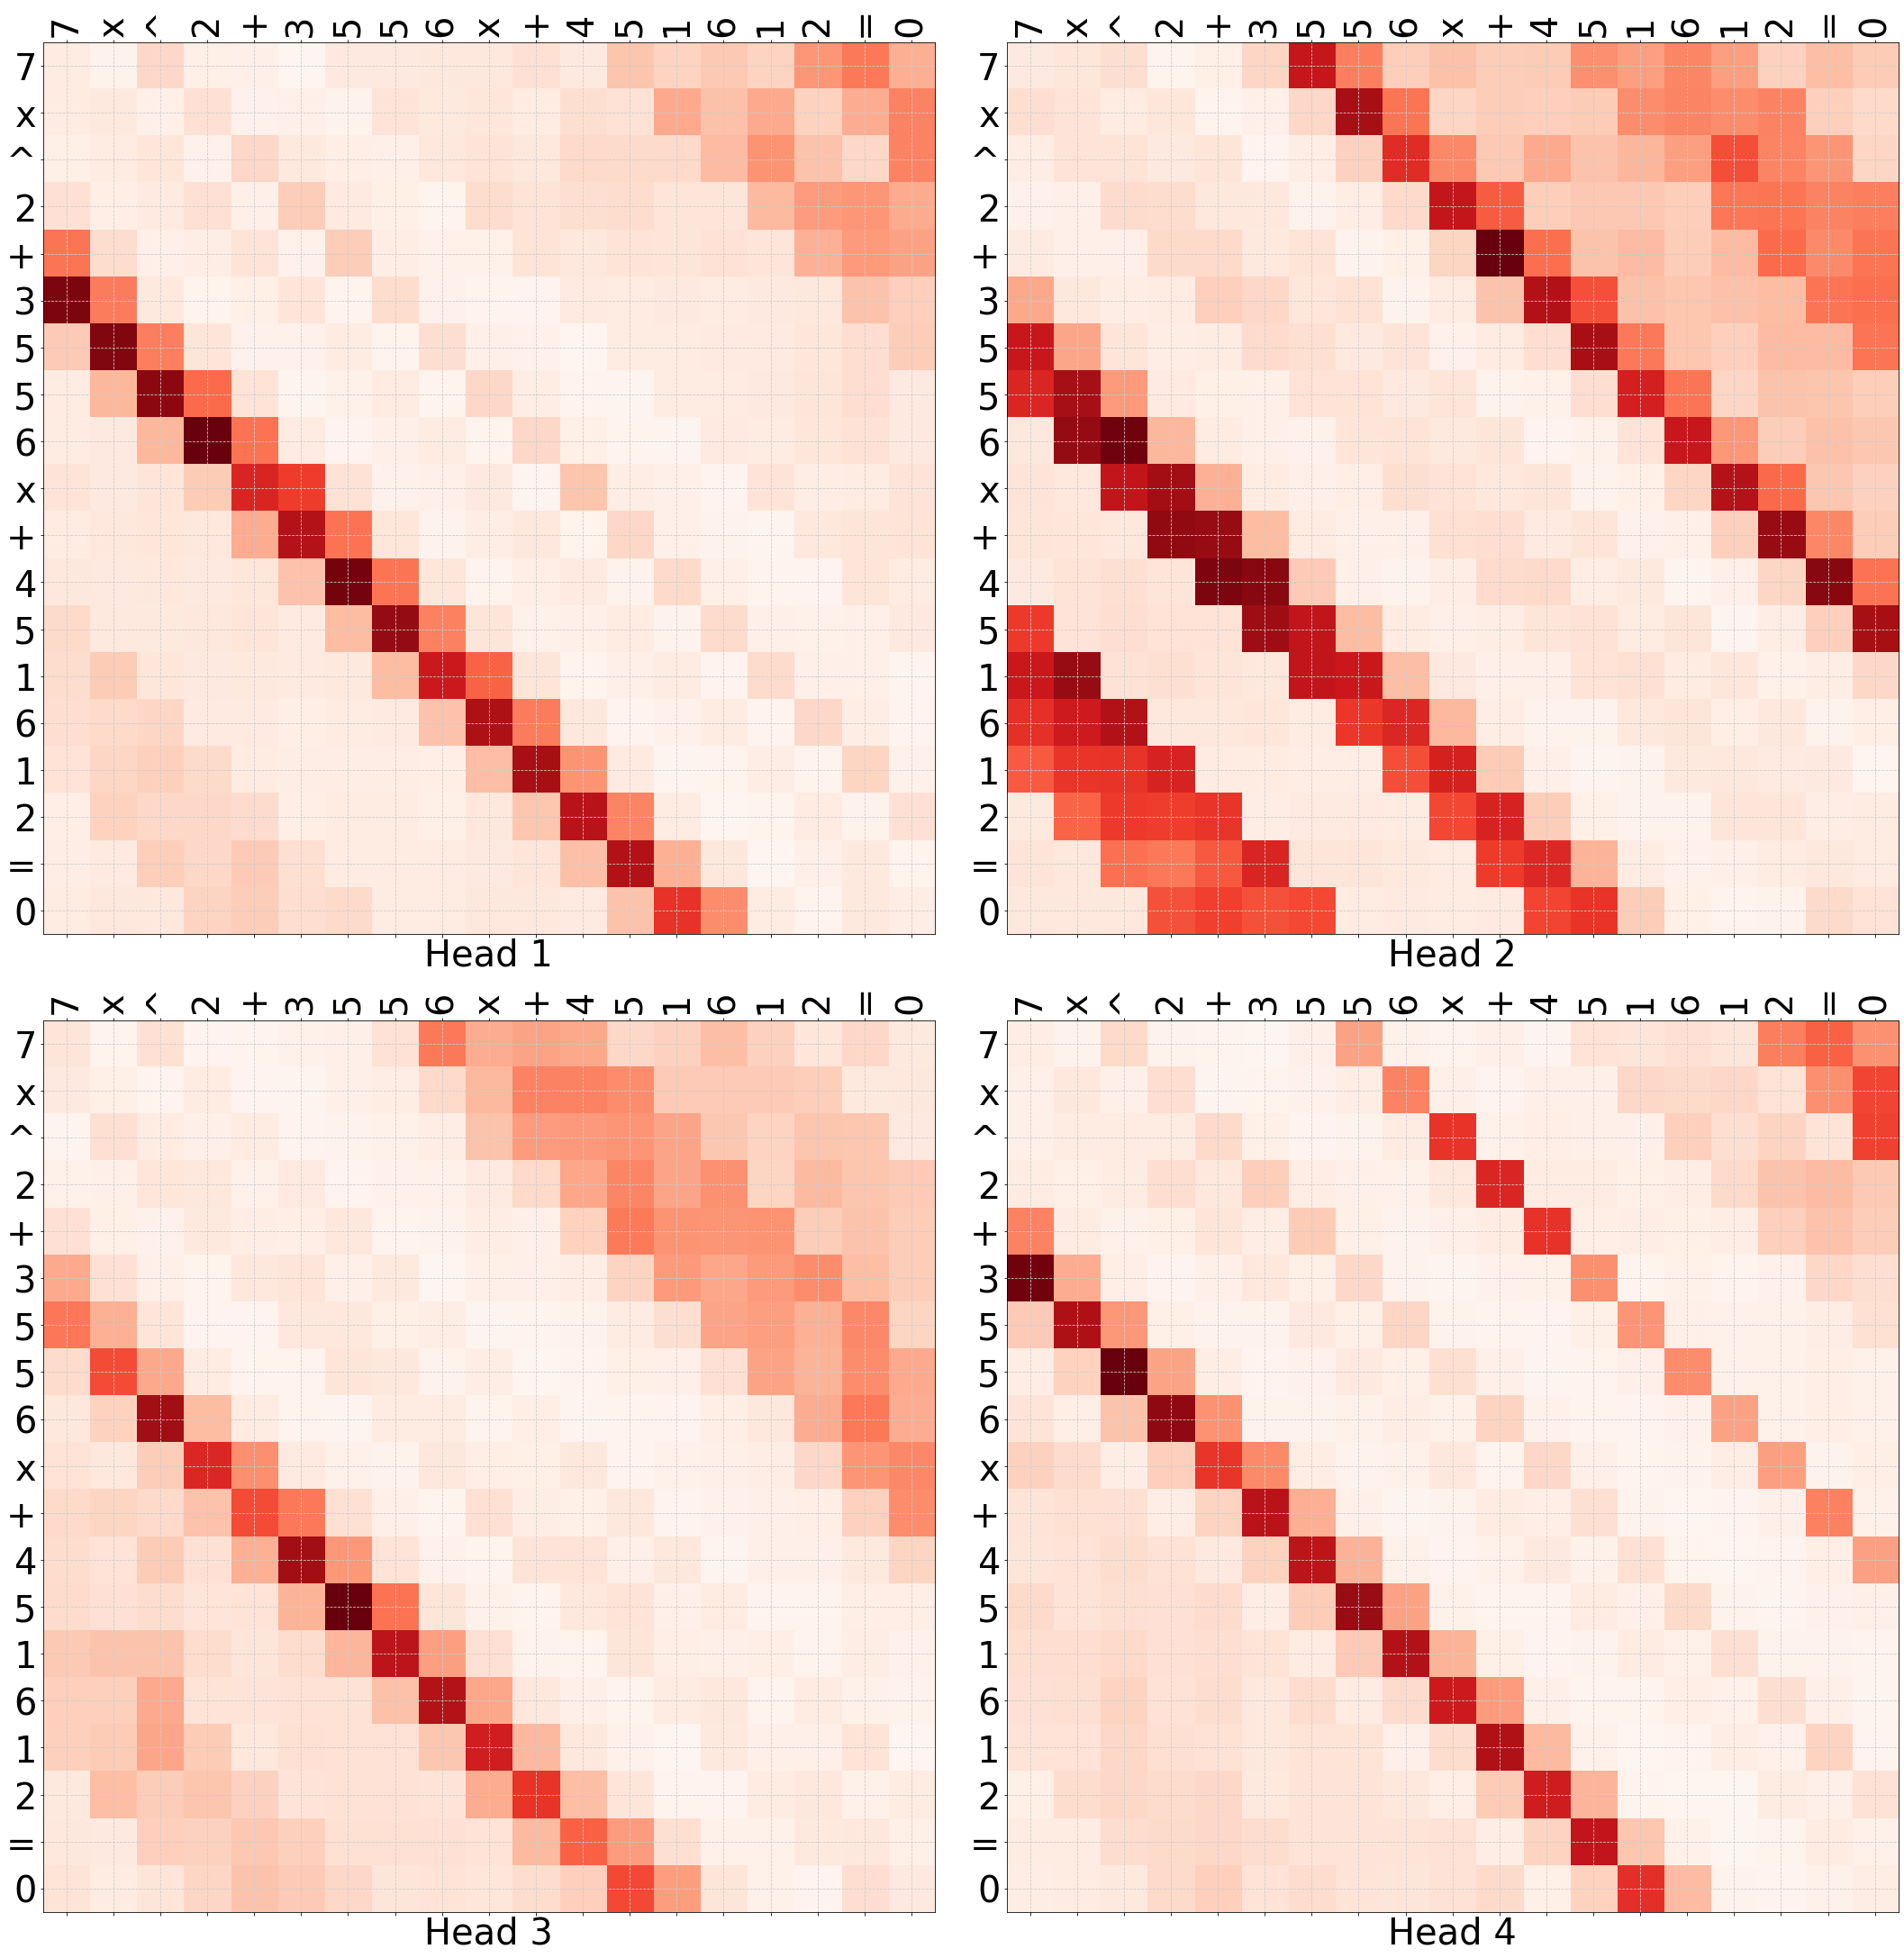

In [713]:
plot_attention_weights_enc(attentions=encoder_attentions[0], tokens=encoder_tokens, layer = 0)

**encoder_attentions on 3 layer:**

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: MatplotlibDeprecationWarning: Passing the fontdict parameter of _set_ticklabels() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.


<Figure size 2160x12960 with 0 Axes>

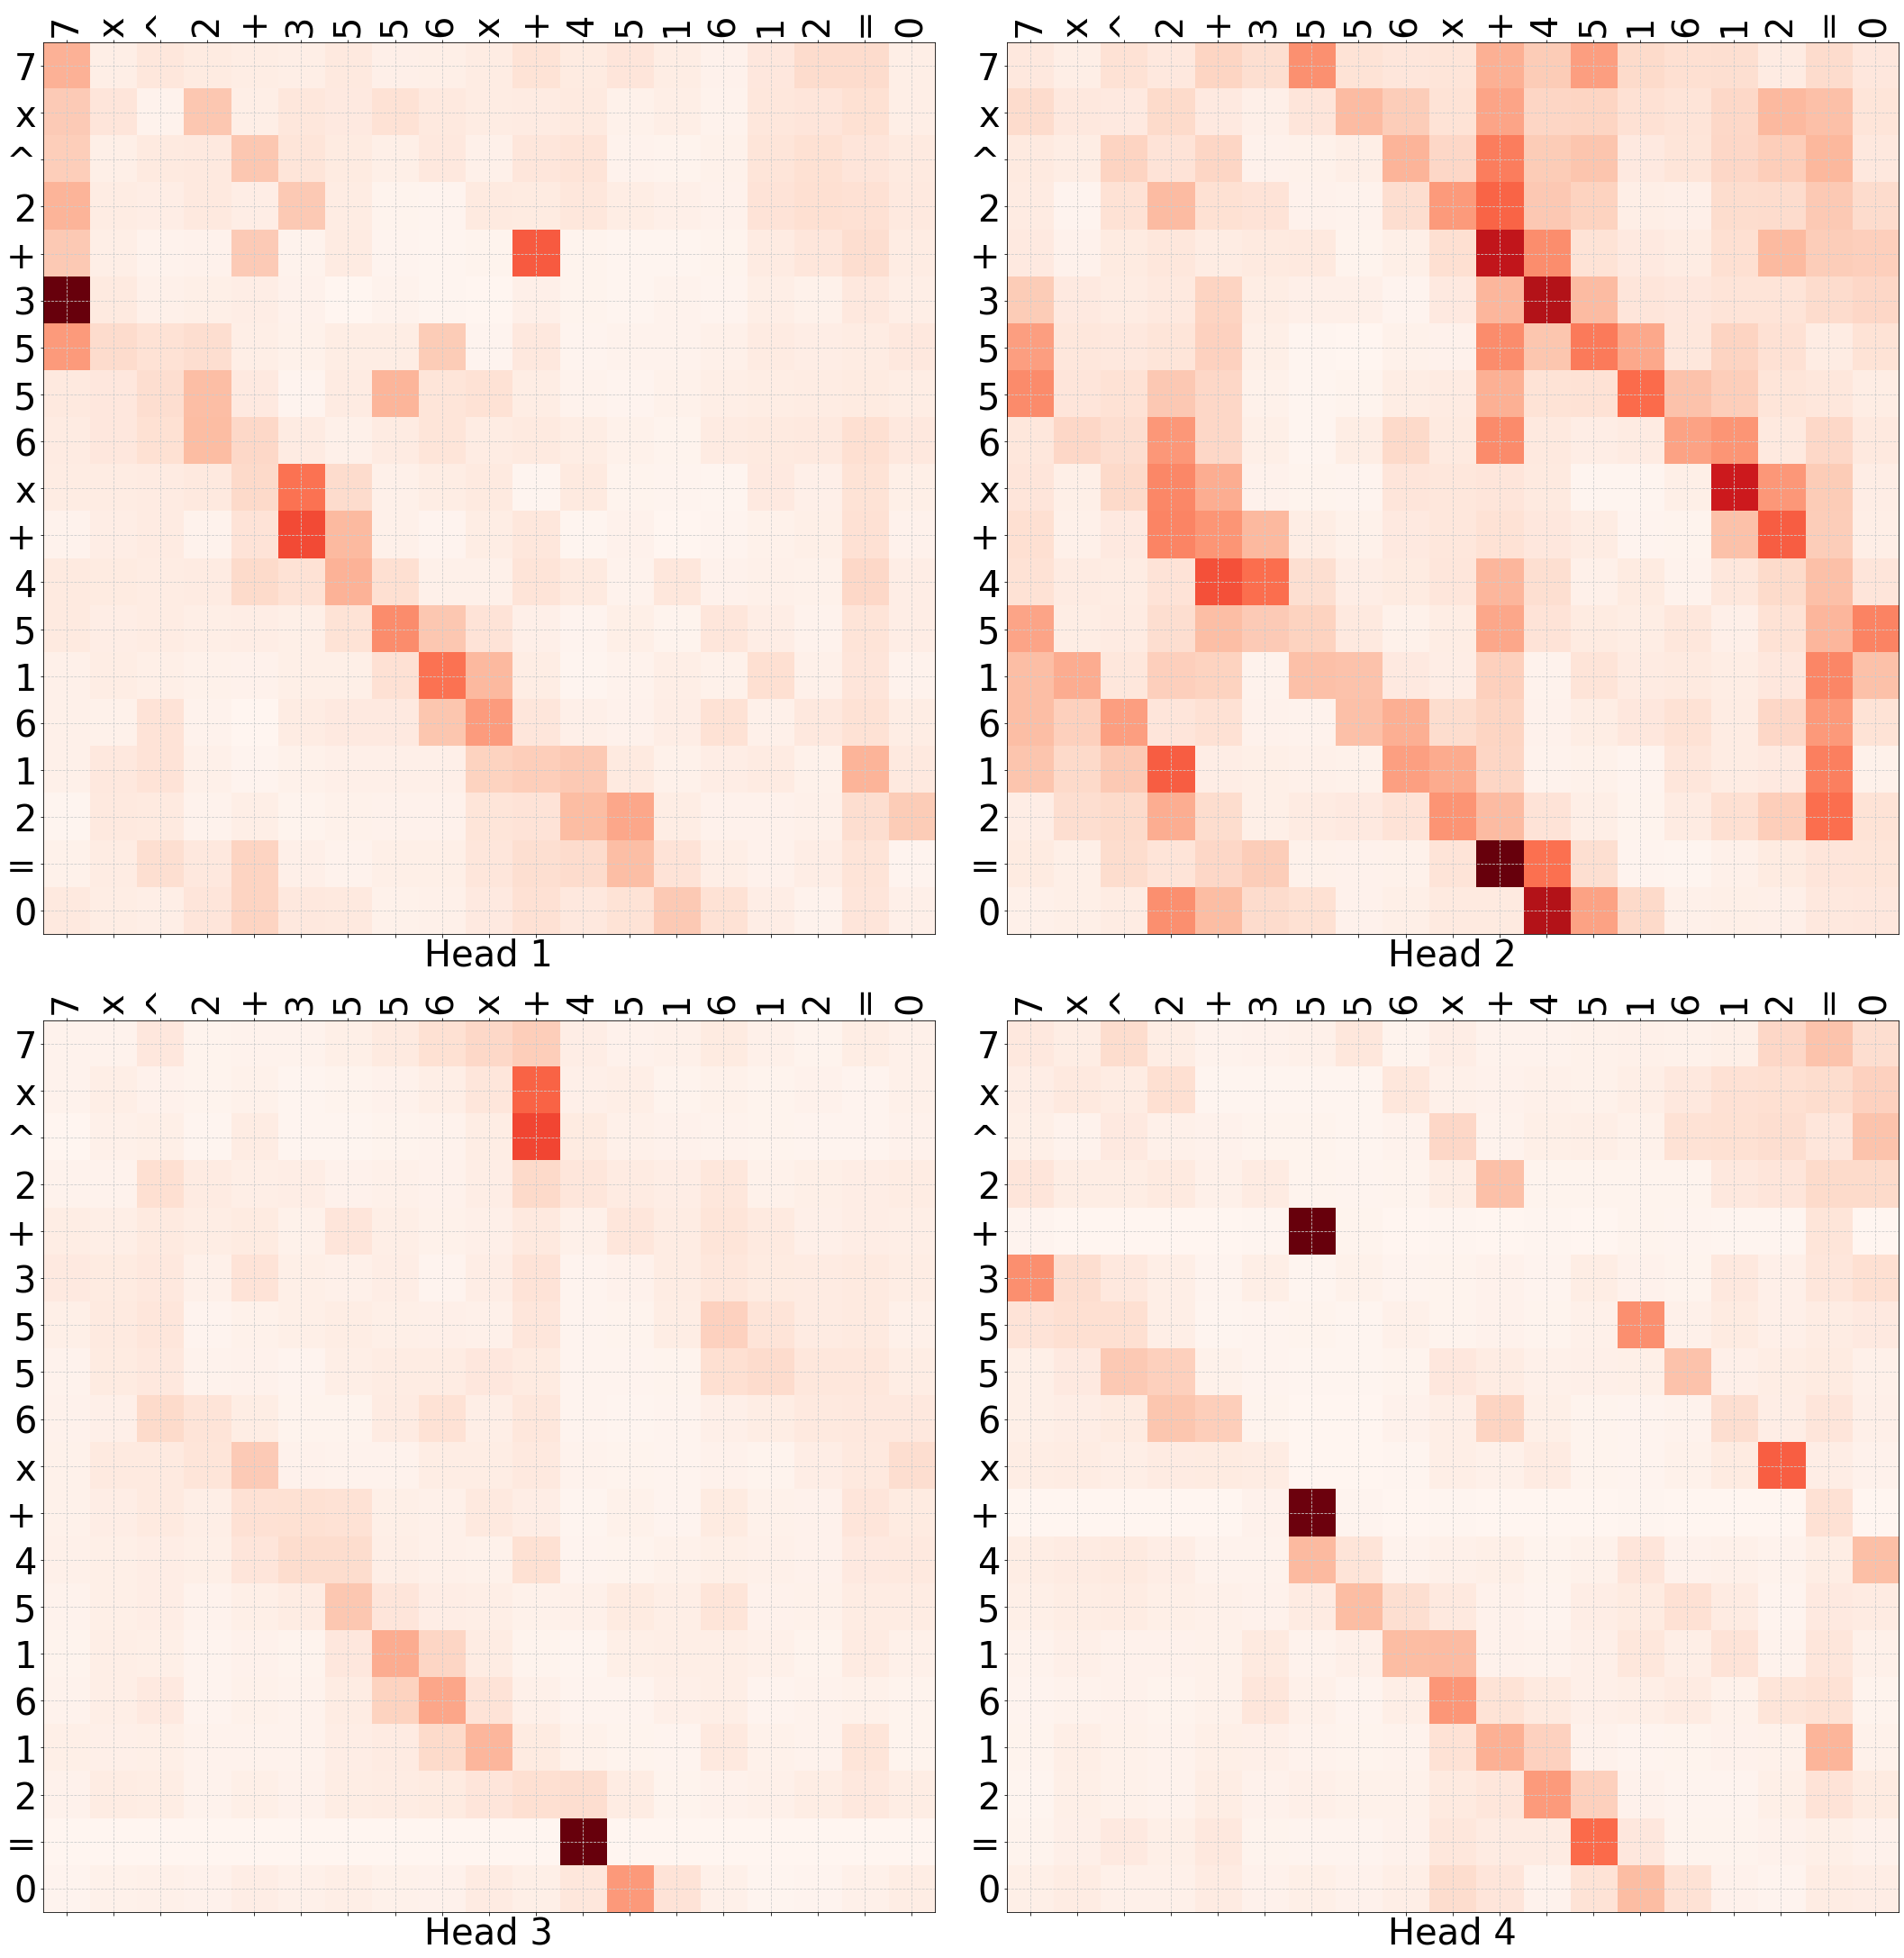

In [763]:
plot_attention_weights_enc(attentions=encoder_attentions[2], tokens=encoder_tokens, layer = 0)

**encoder_attentions on 6 layer:**

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: MatplotlibDeprecationWarning: Passing the fontdict parameter of _set_ticklabels() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.


<Figure size 2160x12960 with 0 Axes>

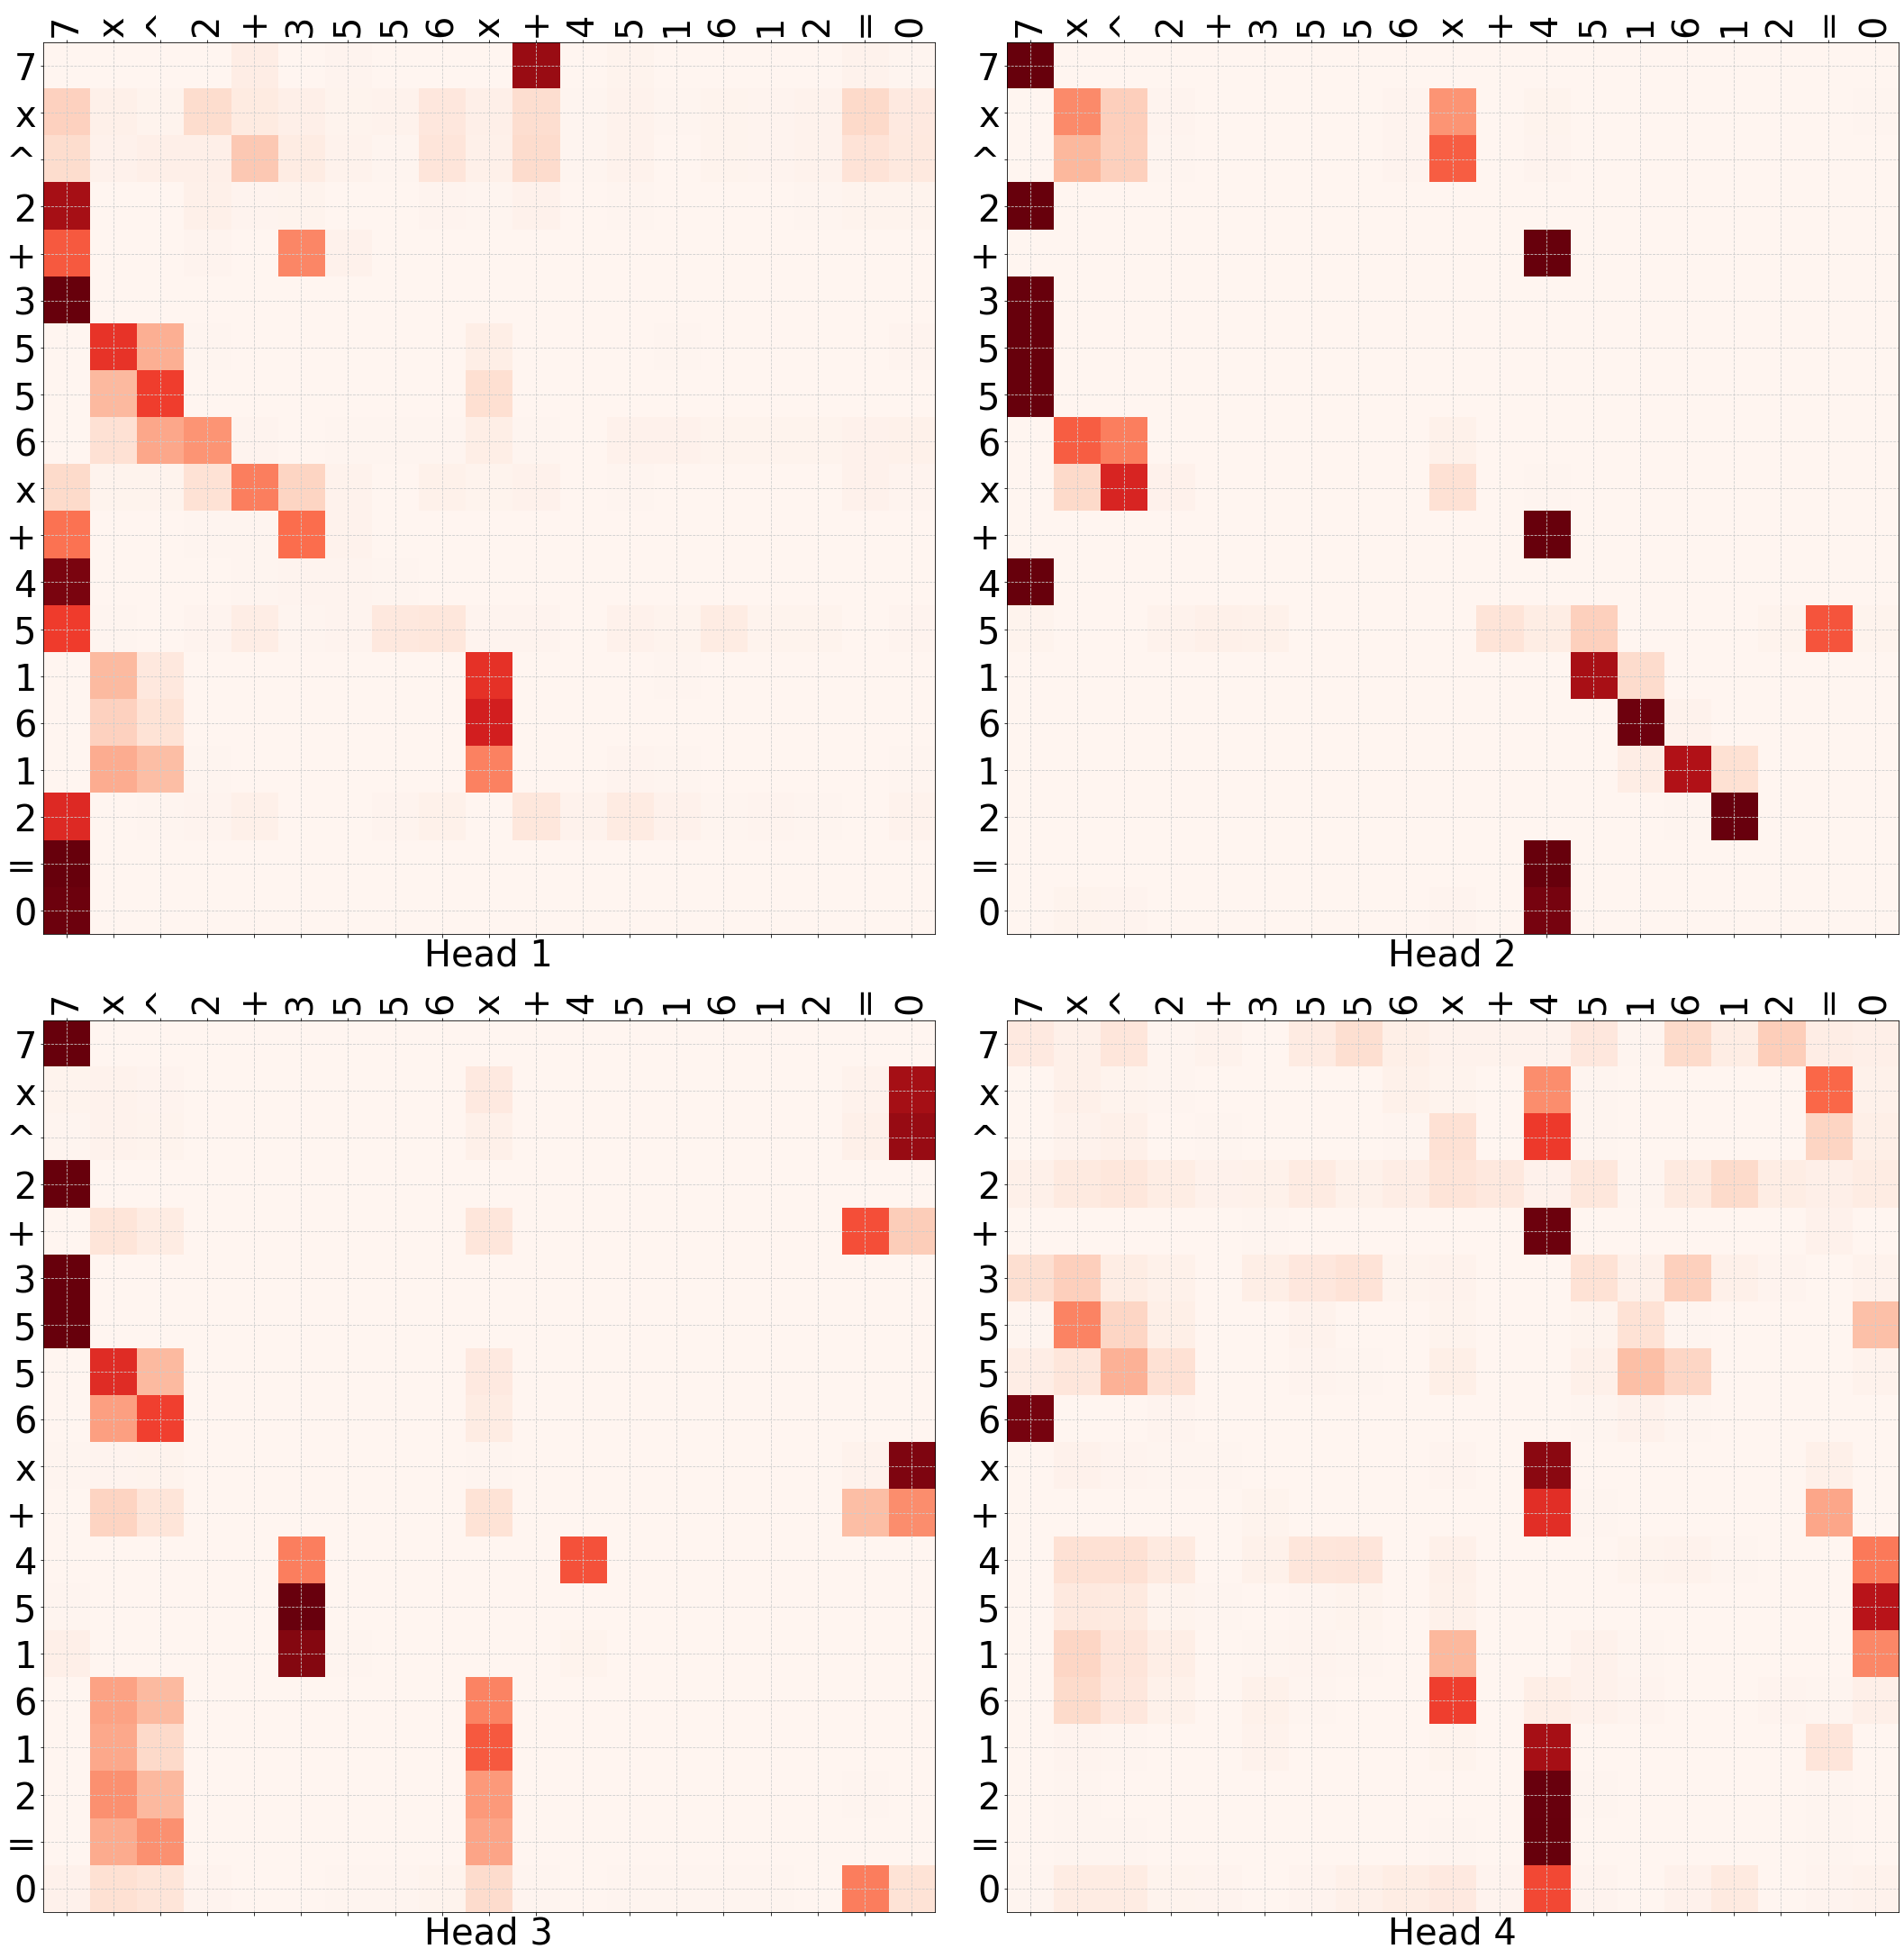

In [764]:
plot_attention_weights_enc(attentions=encoder_attentions[5], tokens=encoder_tokens, layer = 0)

## decoder attentions

In [765]:
decoder_attentions = [t.detach().numpy() for t in decoder_attentions]

In [766]:
from matplotlib import pyplot as plt
%matplotlib inline

import numpy as np

def plot_attention_weights_dec(attentions, tokens, layer, y_tokens=None, p_attentions=None, filename='att.png', save=False):
    fig = plt.figure(figsize=(30, 180))
    if y_tokens is None:
        y_tokens = tokens
        fig = plt.figure(figsize=(30, 90))

    attention = attentions[layer]
    if p_attentions:
        p_attention = p_attentions[layer]

    for head in range(attention.shape[0]):
        ax = fig.add_subplot(6, 2, head+1)
        ax.xaxis.set_major_locator(MultipleLocator(0.5))
        ax.yaxis.set_major_locator(MultipleLocator(0.5))
        
        # plot the attention weights
        if p_attentions:
            att = np.concatenate([np.expand_dims(p_attention[head], axis=0), attention[head]], axis=0)
            ax.matshow(att[:len(y_tokens)+1,:len(tokens)], cmap='Reds')
        else:
            ax.matshow(attention[head][:len(y_tokens),:len(tokens)], cmap='Reds')

        fontdict = {'fontsize': 13}

        ax.set_xticks(range(len(tokens)))
        if p_attentions:
            ax.set_yticks(range(len(y_tokens) + 1))
            ax.set_yticklabels(['[P]'] + y_tokens, fontdict)
        else:
            ax.set_yticks(range(len(y_tokens)))
            ax.set_yticklabels(y_tokens, fontdict)

        ax.set_xticklabels(tokens,fontdict=fontdict, rotation=90)

        ax.set_xlabel('Head {}'.format(head+1), fontdict)
        ax.xaxis.set_minor_locator(AutoMinorLocator(1))
        ax.yaxis.set_minor_locator(AutoMinorLocator(1))

        ax.grid(which='major', color='#CCCCCC', linestyle='--')
        ax.grid(which='minor', color='#CCCCCC', linestyle=':')

    plt.tight_layout()
    if save:
        plt.savefig(filename)
    plt.show()

**decoder_attentions on 6 layer:**

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: MatplotlibDeprecationWarning: Passing the fontdict parameter of _set_ticklabels() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.


<Figure size 2160x12960 with 0 Axes>

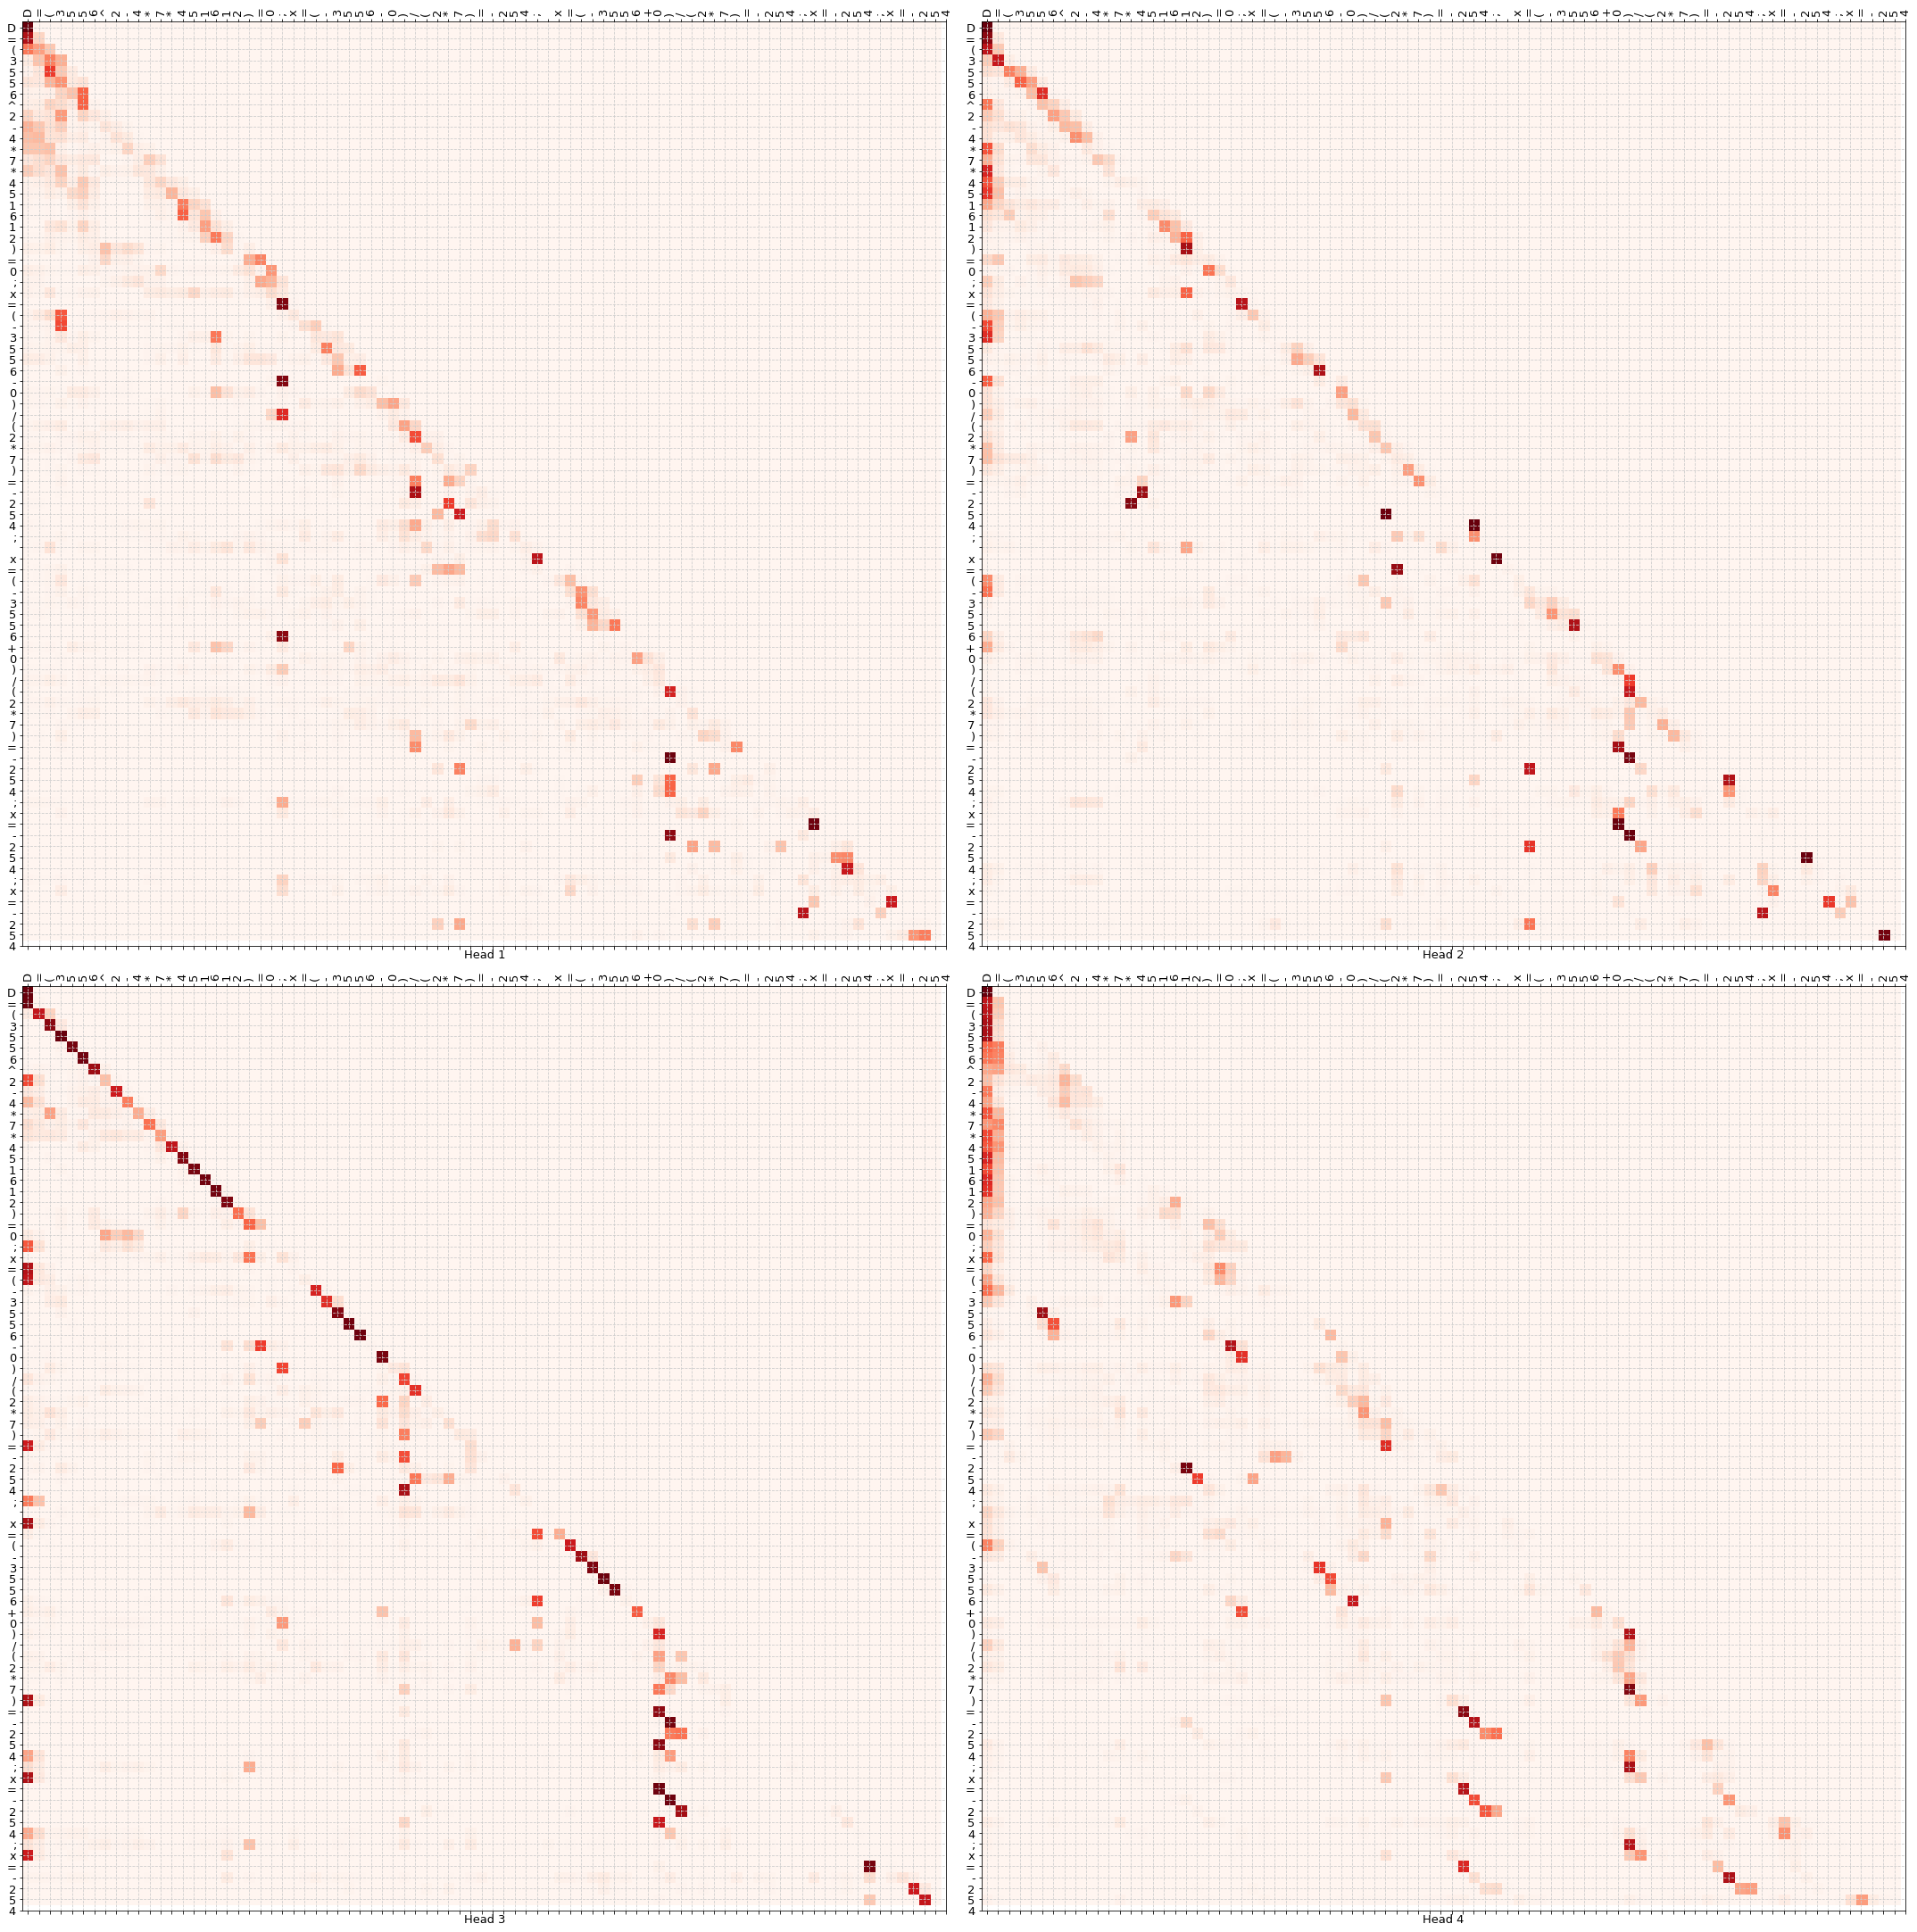

In [357]:
plot_attention_weights_dec(attentions=decoder_attentions[5], tokens=decoder_tokens, layer=0, save=True)

## cross attentions

In [354]:
from matplotlib import pyplot as plt
%matplotlib inline

import numpy as np

def plot_attention_weights_cross(attentions, tokens, layer, y_tokens=None, p_attentions=None, filename='att.png', save=False):
    fig = plt.figure(figsize=(30, 180))
    if y_tokens is None:
        y_tokens = tokens
        fig = plt.figure(figsize=(30, 90))

    attention = attentions[layer]
    if p_attentions:
        p_attention = p_attentions[layer]

    for head in range(attention.shape[0]):
        ax = fig.add_subplot(6, 2, head+1)
        ax.xaxis.set_major_locator(MultipleLocator(0.5))
        ax.yaxis.set_major_locator(MultipleLocator(0.5))
        
        # plot the attention weights
        if p_attentions:
            att = np.concatenate([np.expand_dims(p_attention[head], axis=0), attention[head]], axis=0)
            ax.matshow(att[:len(y_tokens)+1,:len(tokens)], cmap='Reds')
        else:
            ax.matshow(attention[head][:len(y_tokens),:len(tokens)], cmap='Reds')

        fontdict = {'fontsize': 20}

        ax.set_xticks(range(len(tokens)))
        if p_attentions:
            ax.set_yticks(range(len(y_tokens) + 1))
            ax.set_yticklabels(['[P]'] + y_tokens, fontdict)
        else:
            ax.set_yticks(range(len(y_tokens)))
            ax.set_yticklabels(y_tokens, fontdict)

        ax.set_xticklabels(tokens,fontdict=fontdict, rotation=90)

        ax.set_xlabel('Head {}'.format(head+1), fontdict)
        ax.xaxis.set_minor_locator(AutoMinorLocator(1))
        ax.yaxis.set_minor_locator(AutoMinorLocator(1))

        ax.grid(which='major', color='#CCCCCC', linestyle='--')
        ax.grid(which='minor', color='#CCCCCC', linestyle=':')

    plt.tight_layout()
    if save:
        plt.savefig(filename)
    plt.show()

In [296]:
cross_attentions = [t.detach().numpy() for t in cross_attentions]

**cross_attentions on 6 layer:**

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: MatplotlibDeprecationWarning: Passing the fontdict parameter of _set_ticklabels() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.


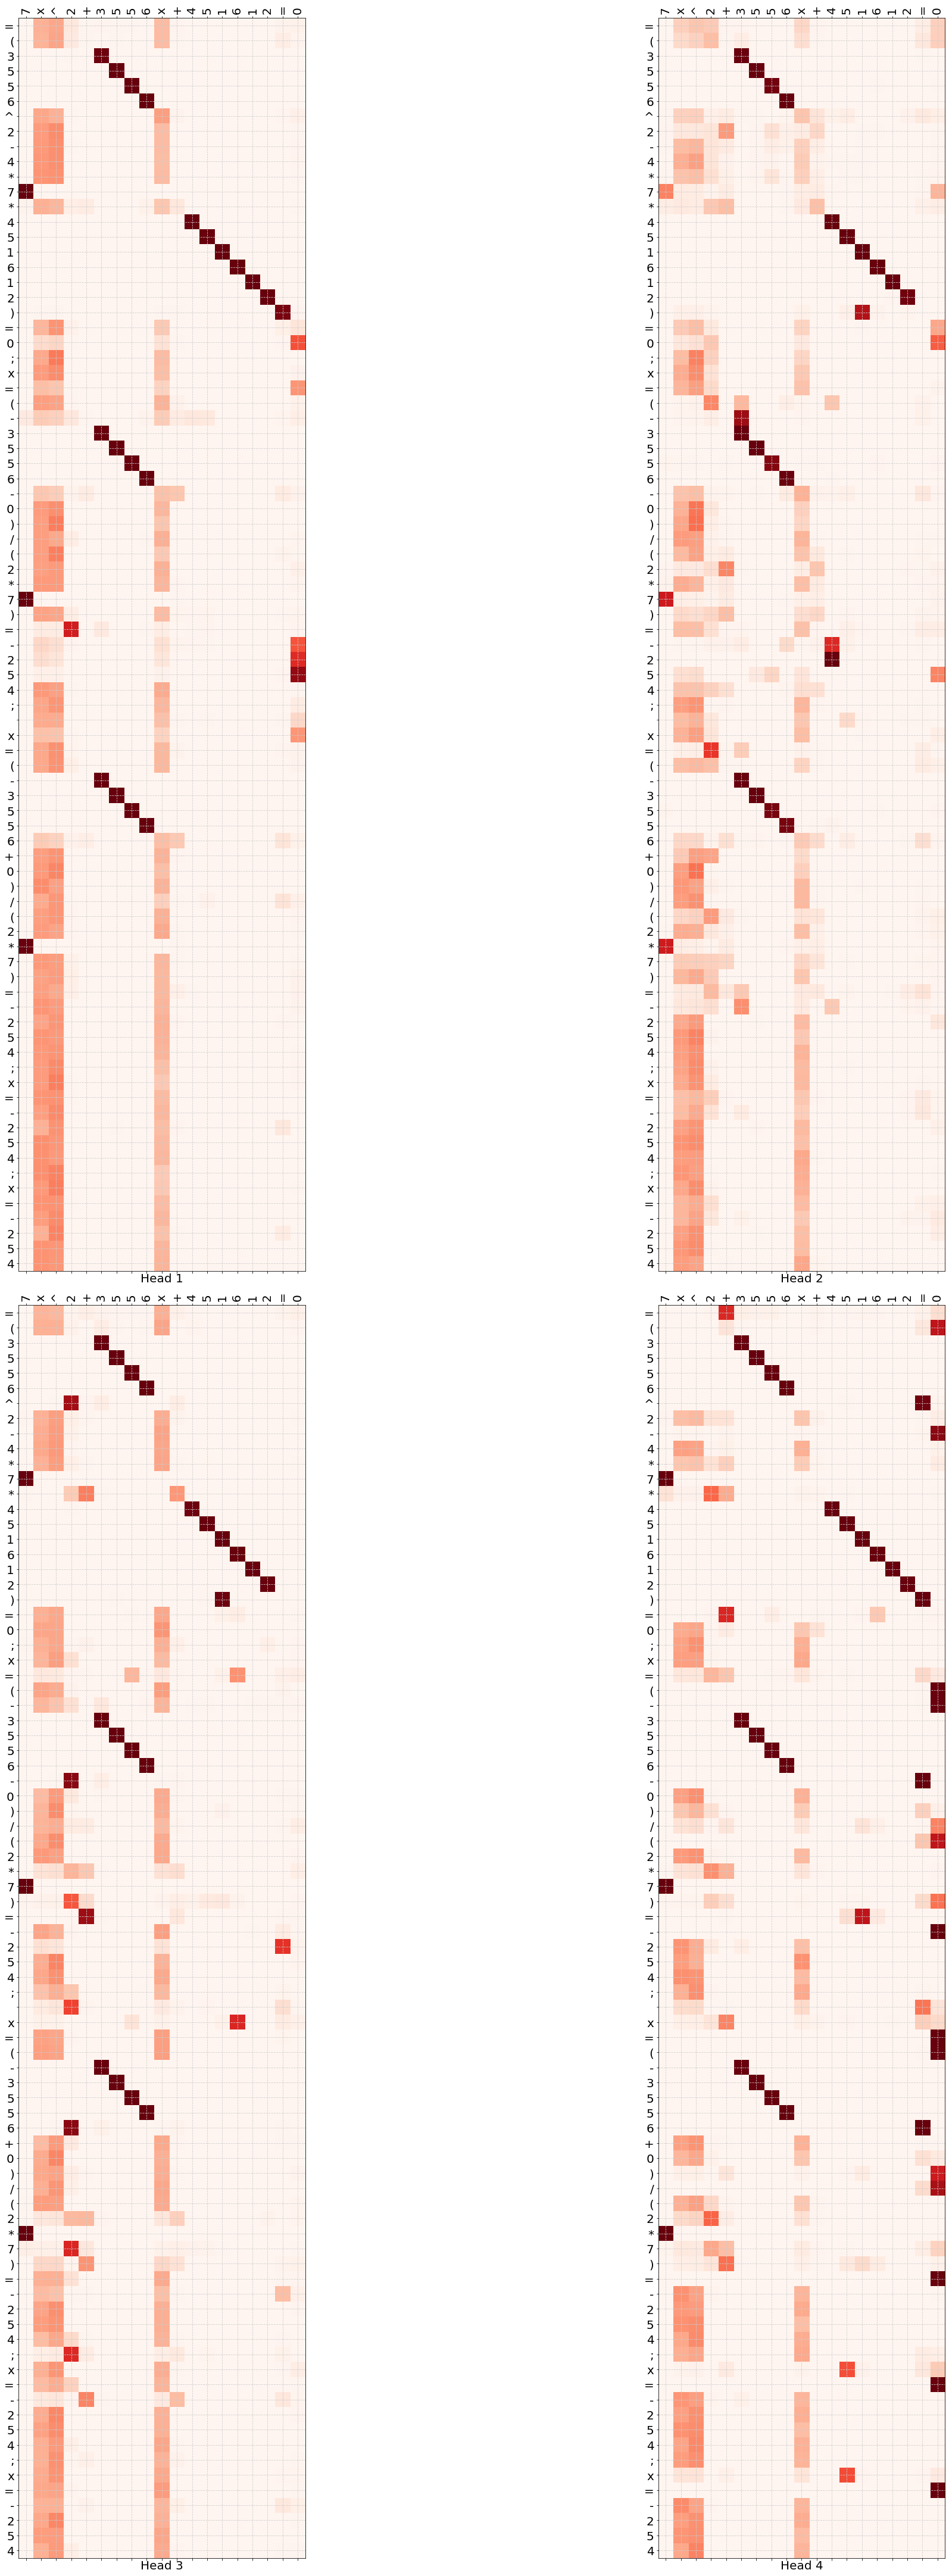

In [664]:
plot_attention_weights_cross(cross_attentions[5], encoder_tokens, layer=0, y_tokens=decoder_tokens, save=True)

## cross/decoder/encoder attentions в увеличенном формате:

In [708]:
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

def get_attentions(outputs, layer=0, attention_head=0, avg=False):
    if avg:
    #avg over all attention heads in a layer
        return outputs[layer].squeeze().mean(dim=0)

  #return values for a particular attention head inside a specific layer
    return outputs[layer].squeeze(0)[attention_head]

def plt_attentions(mat, labs_x, labs_y=None, annot=False, cmap = 'Reds', title=None, save=False):
    fig = plt.figure(figsize=(30, 180))
    if labs_y is None:
        labs_y = labs_x
        fig = plt.figure(figsize=(30, 90))
    ax = fig.add_subplot(6, 2, 1)
    fontdict = {'fontsize': 20}
    ax.xaxis.set_major_locator(MultipleLocator(0.5))
    ax.yaxis.set_major_locator(MultipleLocator(0.5))
    ax = sns.heatmap(mat.cpu().detach().numpy(), annot=annot, yticklabels=labs_y, xticklabels=labs_x, cmap=cmap)
    
    ax.xaxis.set_ticks_position('top')
    ax.set_xticklabels(labs_x, rotation=90, fontdict=fontdict)
    ax.set_yticklabels(labs_y, rotation=90, fontdict=fontdict)
    ax.xaxis.set_minor_locator(AutoMinorLocator(1))
    ax.yaxis.set_minor_locator(AutoMinorLocator(1))

    ax.grid(which='major', color='#CCCCCC', linestyle='--')
    ax.grid(which='minor', color='#CCCCCC', linestyle=':')

    plt.tight_layout()
    if save:
        plt.savefig(filename)
    plt.show()
    if title:
        ax.set_title(title)

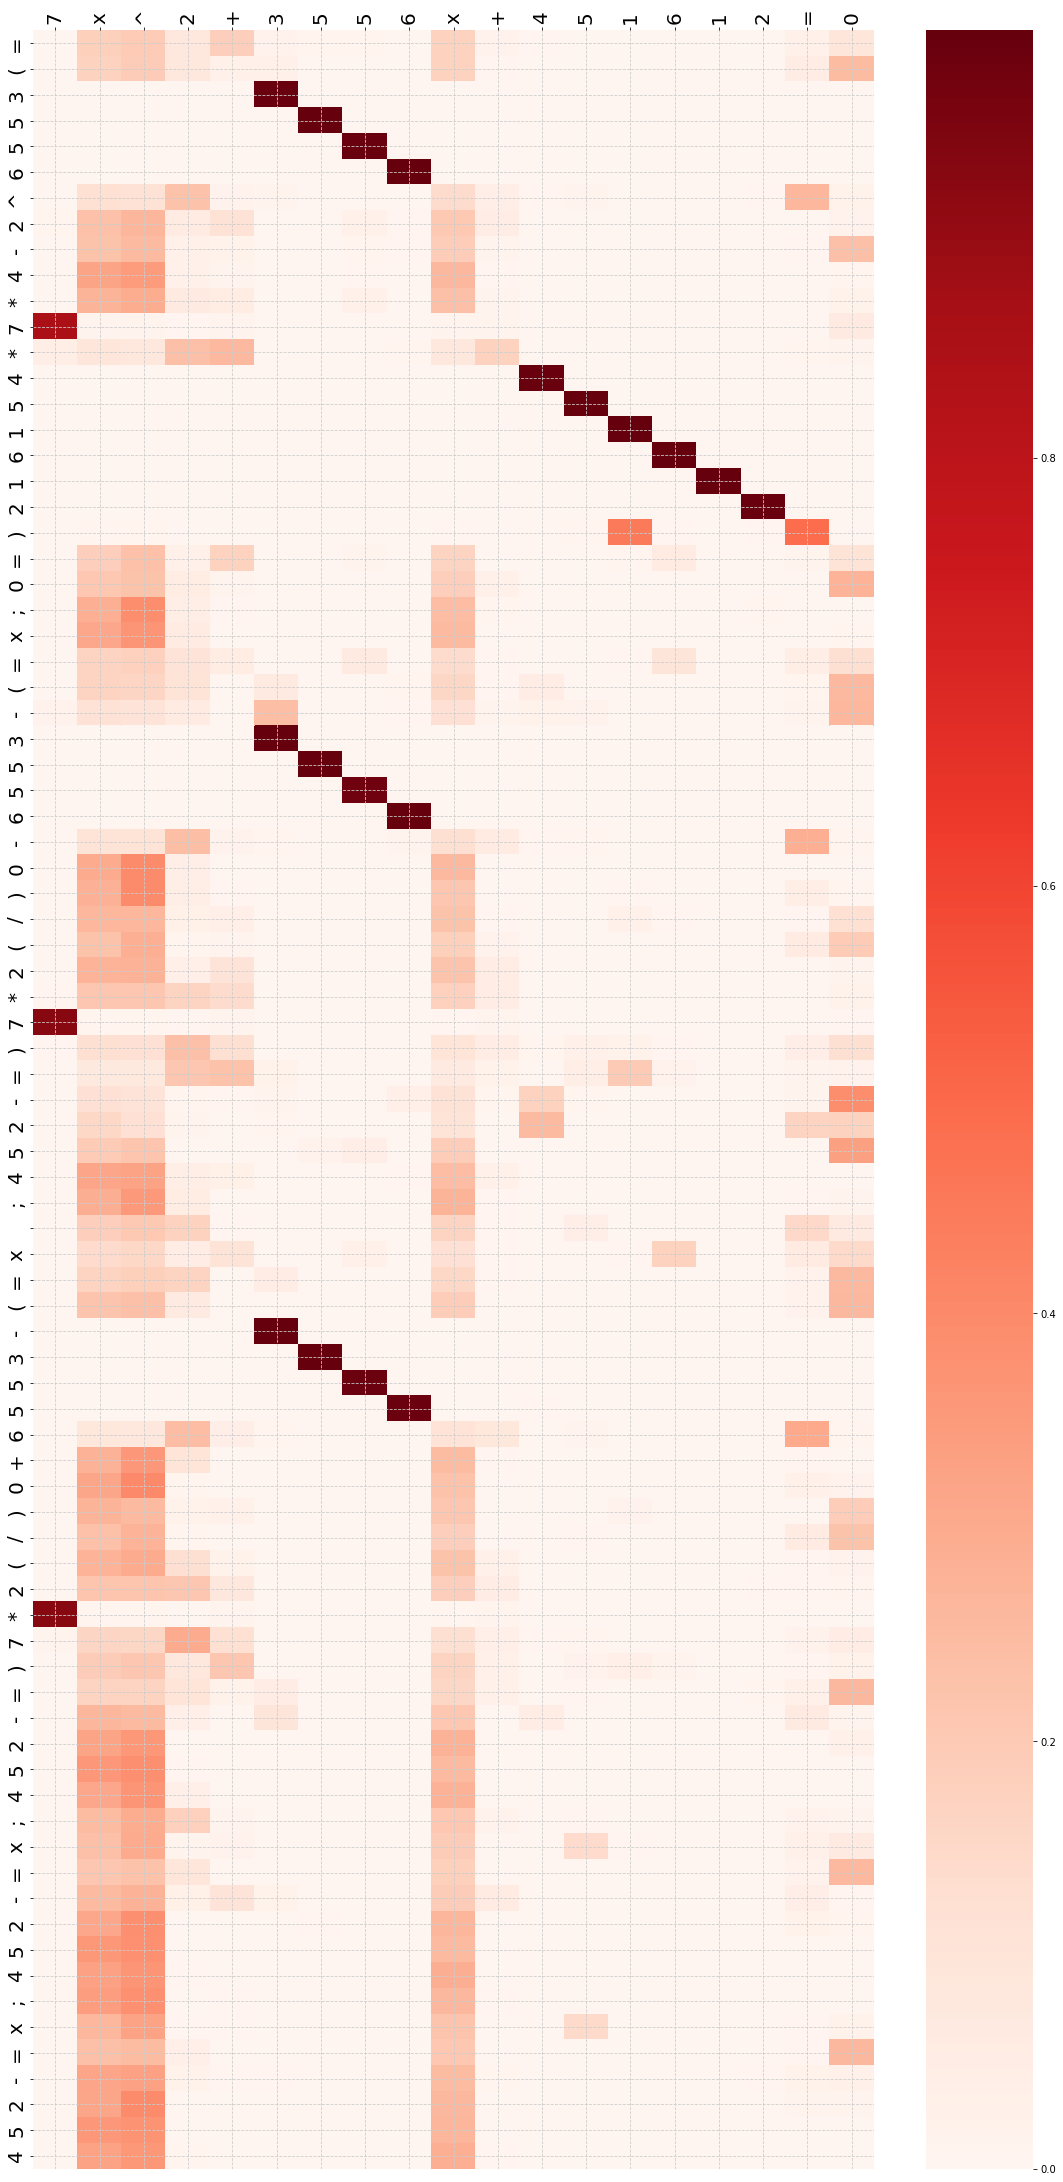

In [471]:
plt_attentions(get_attentions(outputs.cross_attentions, layer=-1, avg = True), encoder_tokens, decoder_tokens)

<Figure size 2160x12960 with 0 Axes>

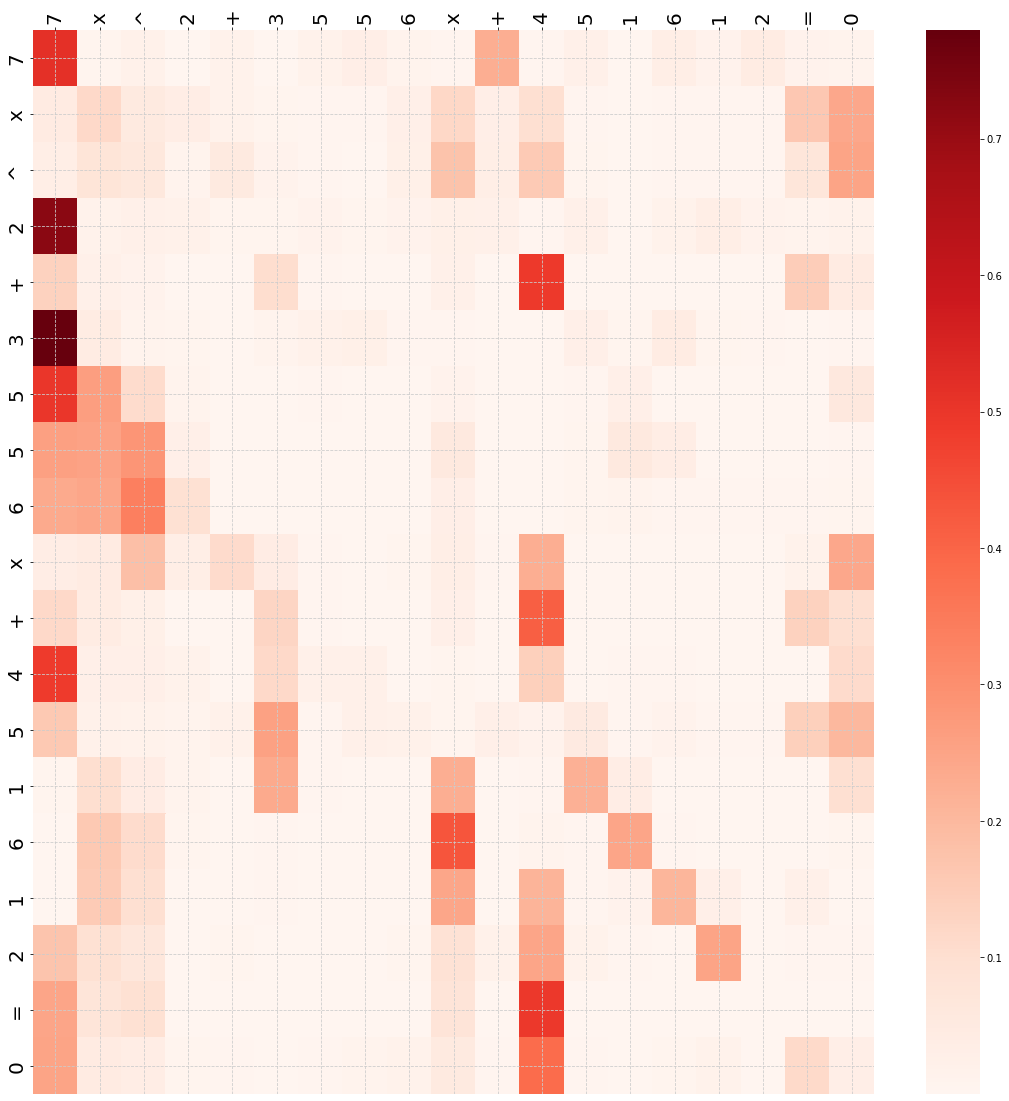

In [475]:
plt_attentions(get_attentions(outputs.encoder_attentions, layer=-1, avg = True), encoder_tokens)

In [ ]:
plt_attentions(get_attentions(outputs.decoder_attentions, layer=-1, avg = True), decoder_tokens)

In [516]:
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

def get_attentions(outputs, layer=0, attention_head=0, avg=False):
    if avg:
    #avg over all attention heads in a layer
        return outputs[layer].squeeze().mean(dim=0)

  #return values for a particular attention head inside a specific layer
    return outputs[layer].squeeze(0)[attention_head]

def plt_attentions_dec(mat, labs_x, labs_y=None, annot=False, cmap = 'Reds', title=None, save=False, filename='att.png'):
    fig = plt.figure(figsize=(30, 180))
    if labs_y is None:
        labs_y = labs_x
        fig = plt.figure(figsize=(30, 90))
    ax = fig.add_subplot(6, 2, 1)
    fontdict = {'fontsize': 12}
    ax.xaxis.set_major_locator(MultipleLocator(0.5))
    ax.yaxis.set_major_locator(MultipleLocator(0.5))
    ax = sns.heatmap(mat.cpu().detach().numpy(), annot=annot, yticklabels=labs_y, xticklabels=labs_x, cmap=cmap)
    
    ax.xaxis.set_ticks_position('top')
    ax.set_xticklabels(labs_x, rotation=90, fontdict=fontdict)
    ax.set_yticklabels(labs_y, rotation=90, fontdict=fontdict)
    ax.xaxis.set_minor_locator(AutoMinorLocator(1))
    ax.yaxis.set_minor_locator(AutoMinorLocator(1))

    ax.grid(which='major', color='#CCCCCC', linestyle='--')
    ax.grid(which='minor', color='#CCCCCC', linestyle=':')

    plt.tight_layout()
    if save:
        plt.savefig(filename)
    plt.show()
    if title:
        ax.set_title(title)

##  map attentions on layers 

In [654]:
import matplotlib.pyplot as plt
import numpy as np


def get_sum_tokens_on_layer(mat, lab_x, lab_y=None, annot=False, cmap = 'Reds', title=None, save=False, filename='summ_att.png', cross=False):
    k = torch.vstack(mat).mean(dim=(1)).mean(dim=1)
    if cross:
        k = torch.vstack(mat).mean(axis=1).mean(axis=1)
    layers_num = ['layer 1','layer 2','layer 3','layer 4','layer 5','layer 6']
    fig = plt.figure(figsize=(30, 90))
    ax = fig.add_subplot(6, 2, 1)
    fontdict = {'fontsize': 12}
    ax.xaxis.set_major_locator(MultipleLocator(1))
    ax.yaxis.set_major_locator(MultipleLocator(1))
    ax = sns.heatmap(k.cpu().detach().numpy(), annot=False, yticklabels=layers_num, xticklabels=lab_x, cmap='Reds')

    ax.xaxis.set_ticks_position('top')
    ax.set_xticklabels(lab_x, rotation=90, fontdict=fontdict)
    ax.set_yticklabels(layers_num, rotation=90, fontdict=fontdict)
    ax.xaxis.set_minor_locator(AutoMinorLocator(1))
    ax.yaxis.set_minor_locator(AutoMinorLocator(1))

    ax.grid(which='major', color='#CCCCCC', linestyle='--')
    ax.grid(which='minor', color='#CCCCCC', linestyle=':')

    plt.tight_layout()
    if save:
        plt.savefig(filename)
    plt.show()

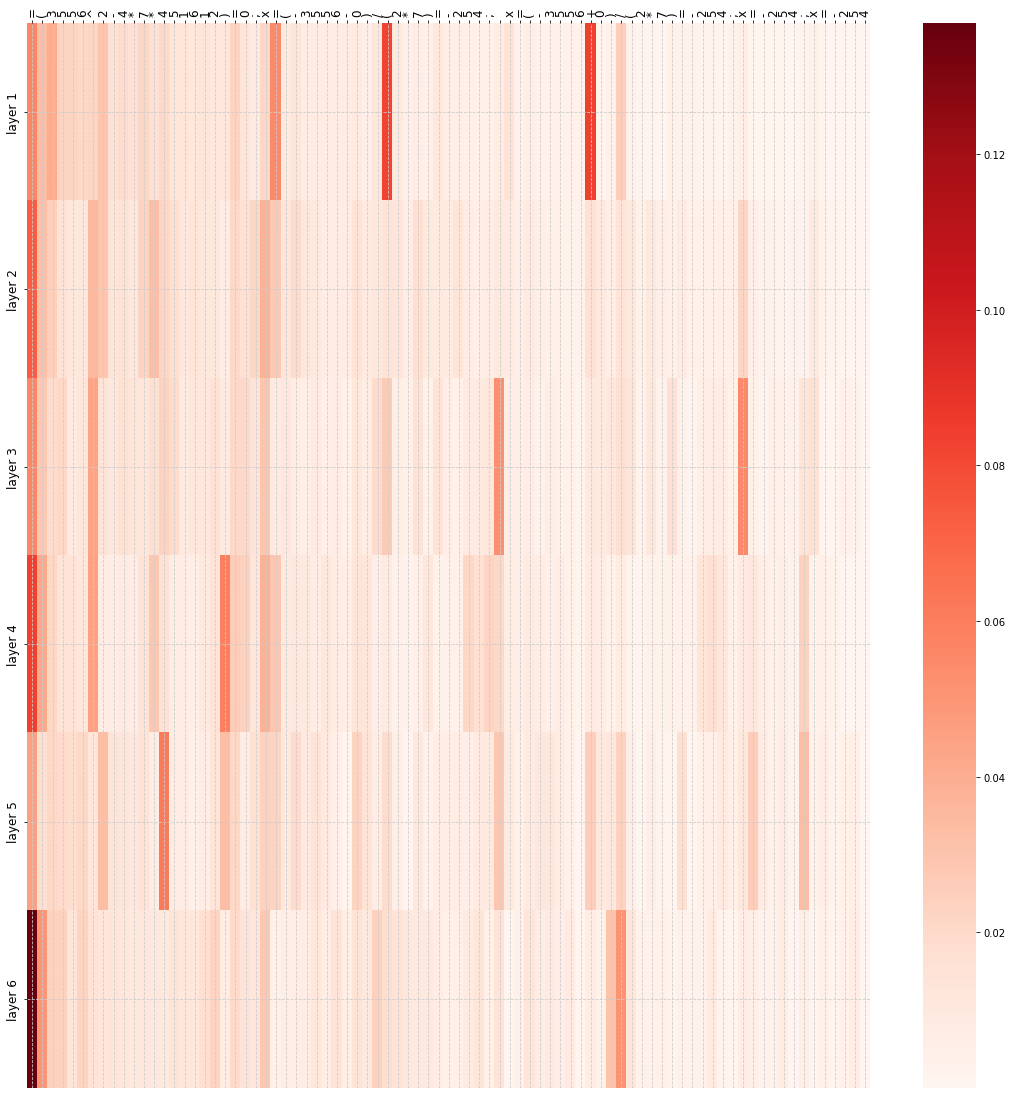

In [611]:
get_sum_tokens_on_layer(outputs.decoder_attentions, decoder_tokens)

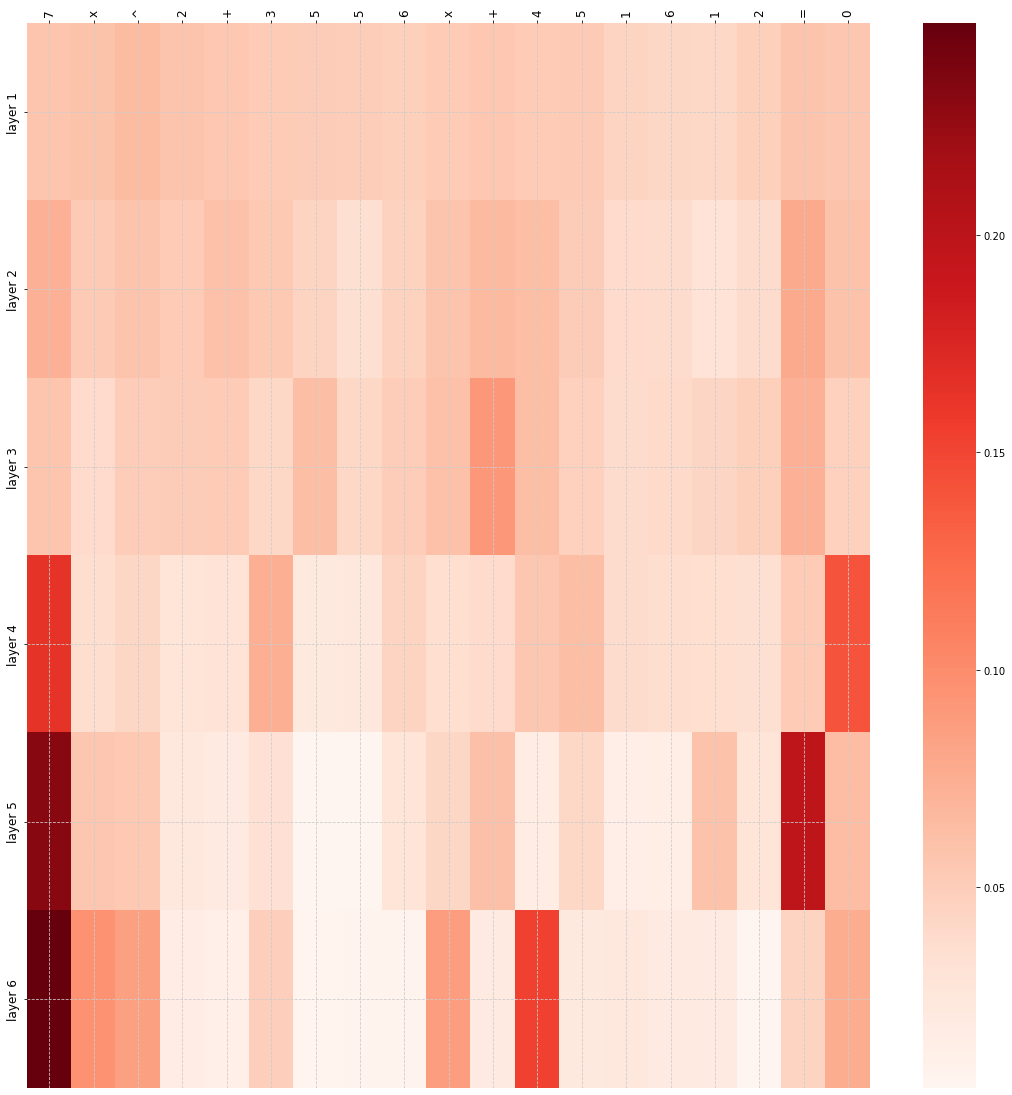

In [612]:
get_sum_tokens_on_layer(outputs.encoder_attentions, encoder_tokens)

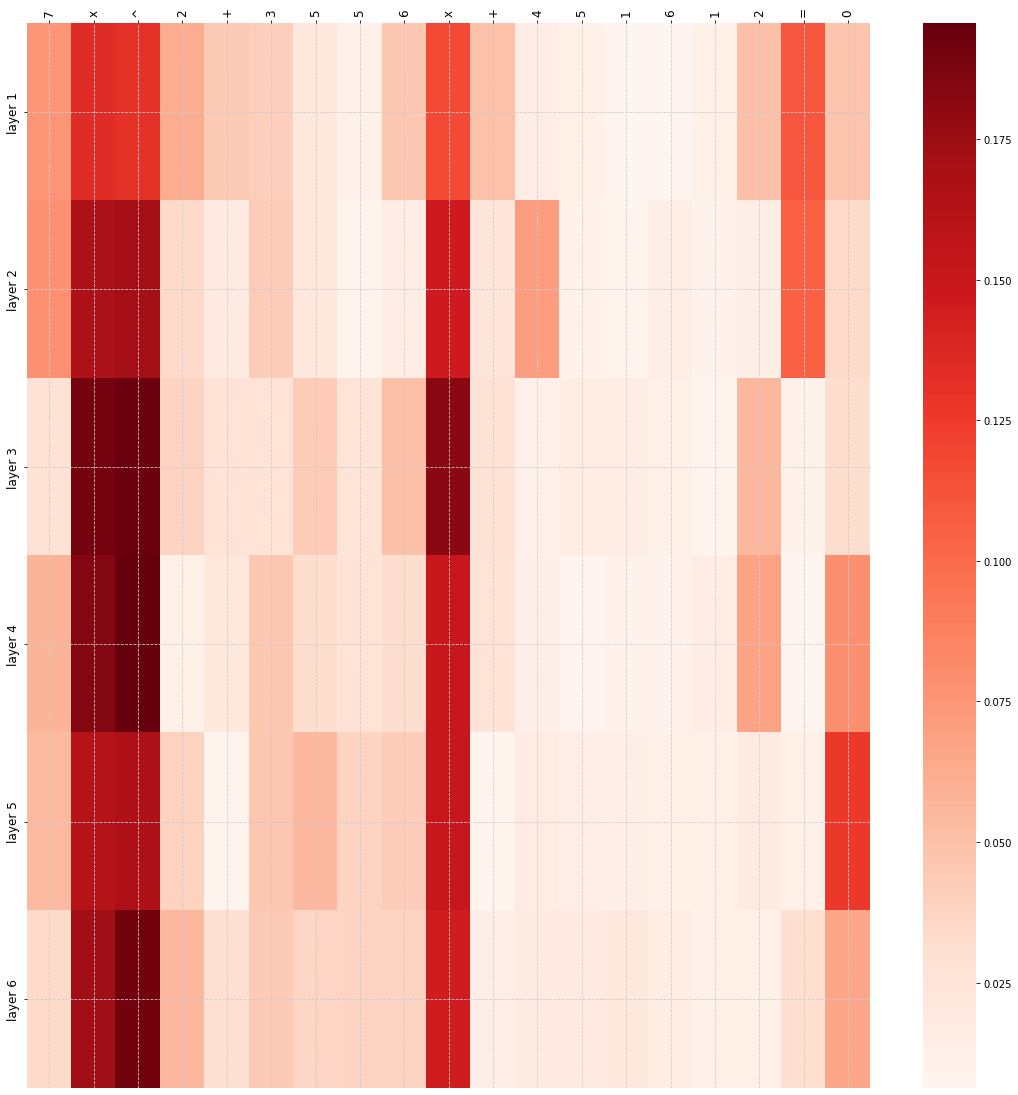

In [655]:
get_sum_tokens_on_layer(outputs.cross_attentions, encoder_tokens, cross=True)

In [ ]:
decoder_on_layers = torch.vstack(outputs.decoder_attentions).mean(dim=(1)).mean(dim=1)

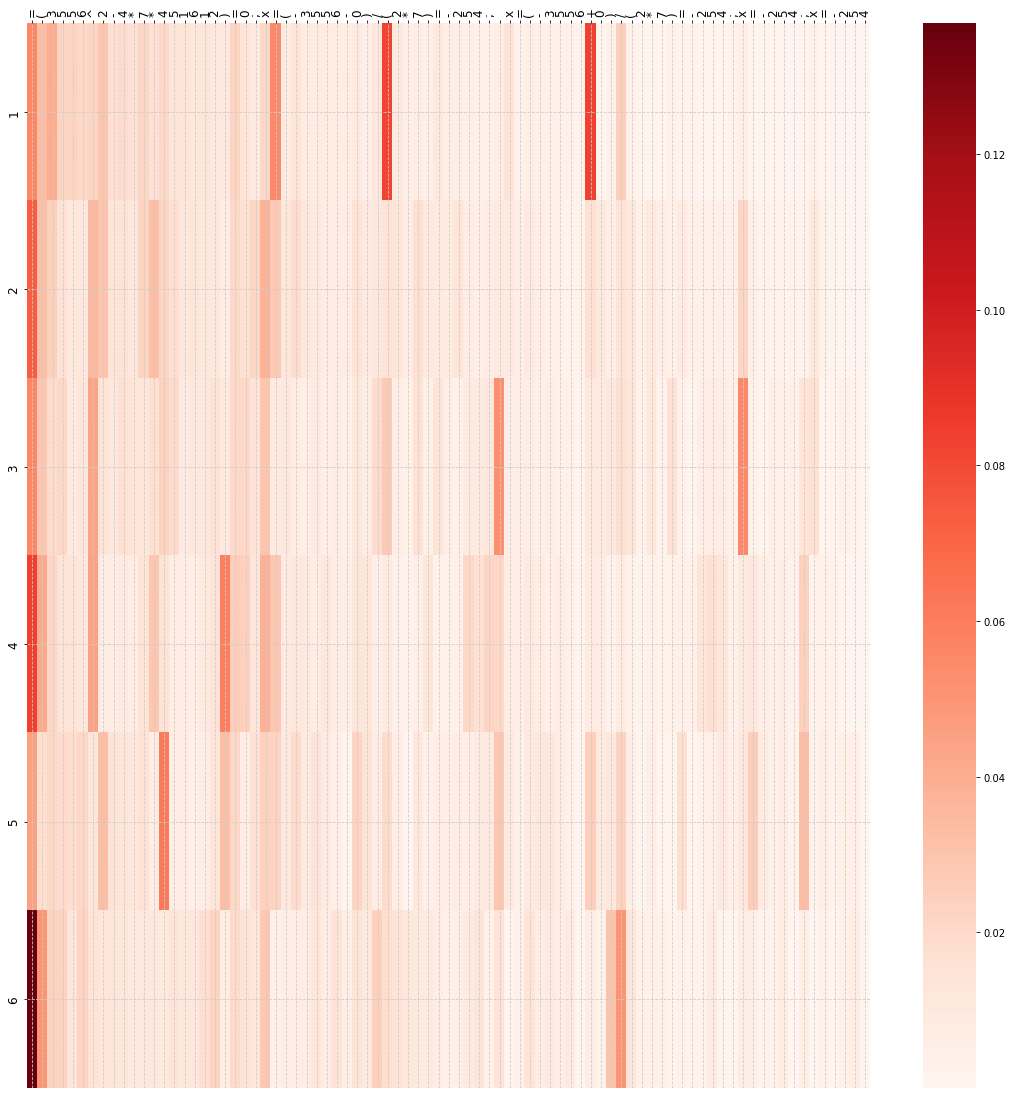

In [593]:
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure(figsize=(30, 90))
ax = fig.add_subplot(6, 2, 1)
fontdict = {'fontsize': 12}
ax.xaxis.set_major_locator(MultipleLocator(1))
ax.yaxis.set_major_locator(MultipleLocator(1))
ax = sns.heatmap(decoder_on_layers.cpu().detach().numpy(), annot=False, yticklabels=k2, xticklabels=decoder_tokens, cmap='Reds')

ax.xaxis.set_ticks_position('top')
ax.set_xticklabels(decoder_tokens, rotation=90, fontdict=fontdict)
ax.set_yticklabels(k2, rotation=90, fontdict=fontdict)
ax.xaxis.set_minor_locator(AutoMinorLocator(1))
ax.yaxis.set_minor_locator(AutoMinorLocator(1))

ax.grid(which='major', color='#CCCCCC', linestyle='--')
ax.grid(which='minor', color='#CCCCCC', linestyle=':')

plt.tight_layout()
plt.show()

In [ ]:
def plt_attentions(mat, labs_x, labs_y=6, annot=False, cmap = 'Reds', title=None, save=False):
    fig = plt.figure(figsize=(30, 180))
    if labs_y is None:
        labs_y = labs_x
        fig = plt.figure(figsize=(30, 90))
    ax = fig.add_subplot(6, 2, 1)
    fontdict = {'fontsize': 20}
    ax.xaxis.set_major_locator(MultipleLocator(0.5))
    ax.yaxis.set_major_locator(MultipleLocator(0.5))
    
    ax = sns.heatmap(mat.cpu().detach().numpy(), annot=annot, yticklabels=labs_y, xticklabels=labs_x, cmap=cmap)
    
    ax.xaxis.set_ticks_position('top')
    ax.set_xticklabels(labs_x, rotation=90, fontdict=fontdict)
    ax.set_yticklabels(labs_y, rotation=90, fontdict=fontdict)
    ax.xaxis.set_minor_locator(AutoMinorLocator(1))
    ax.yaxis.set_minor_locator(AutoMinorLocator(1))


    ax.grid(which='major', color='#CCCCCC', linestyle='--')
    ax.grid(which='minor', color='#CCCCCC', linestyle=':')

    plt.tight_layout()
    if save:
        plt.savefig(filename)
    plt.show()
    if title:
        ax.set_title(title)

<Figure size 2160x12960 with 0 Axes>

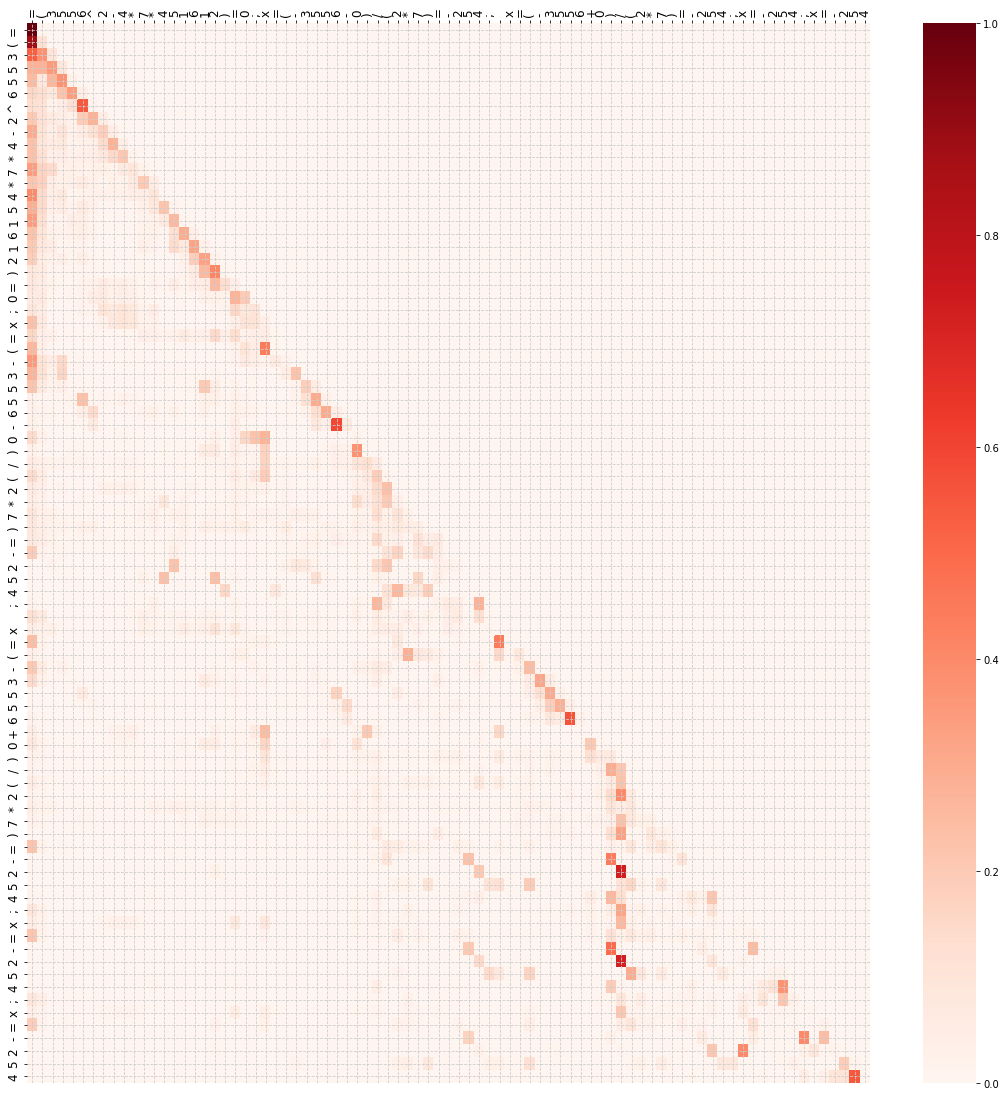

In [517]:
plt_attentions_dec(get_attentions(outputs.decoder_attentions, layer=-1, avg = True), decoder_tokens, save=True)